La versione senza normalizzazione impara una cosa che assomiglia a quello che trovavo nel caso con solo 2 round.

In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/home/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [110]:
experiment_id = "Dop8V030"
# round_ids = ["ARN", "R01", "R01CS", "R02N", "R02F", "R02S", "R02SF"]
# round_ids = ["ARN", "R01", "R01CS", "R02N"]
round_ids = ["ARN", "R01", "R01CS", "R02N", "R02F", "R02S", "R02SF"]

dtype = torch.float32

In [111]:
sequences = []
for round_id in round_ids:
    s = utils.sequences_from_file(experiment_id, round_id, device=torch.device("cpu"))
    sequences.append(s)
    print(f"finished {round_id}")

finished ARN
finished R01
finished R01CS
finished R02N
finished R02F
finished R02S
finished R02SF


In [112]:
sequences_oh = [one_hot(seq).to(dtype=dtype, device=torch.device("cpu")) for seq in sequences]

In [113]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [205]:
import importlib
importlib.reload(utils)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)
importlib.reload(training)
importlib.reload(callback)

<module 'callback' from '/home/scrotti/Aptamer2025py/callback.py'>

In [210]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")
tr.add_node(0, name = "R02F")
tr.add_node(0, name = "R02S")
tr.add_node(0, name = "R02SF")

picked_round_idx = [0, 1, 3, 4, 5, 6]

mode_names = ["NA, NW", "FA, NW", "NA, HW", "FA, HW"]

selected_modes = torch.BoolTensor(
    [[1, 0, 0, 0],
     [1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 1]]
)

n_selection_rounds, n_modes = selected_modes.size()
assert n_selection_rounds == len(picked_round_idx) - 1
n_rounds = n_selection_rounds + 1

In [211]:
L, q = sequences_oh[0][0].shape

k = torch.randn(L, q, dtype=dtype)
k = torch.log(fi0)

potts_modes = []
for _ in range(n_modes):
    h = torch.randn(L, q, dtype=dtype) * 1e-1
    J_ = torch.randn(L*q, L*q, dtype=dtype) * 1e-2
    J_ = J_ + J_.t()
    J = J_.reshape(L, q, L, q)
    potts = energy_models.Potts(J, h)
    potts_modes.append(potts)

Ns0 = energy_models.IndepSites(k)
# unbound_mode = energy_models.ConstantEnergy(-10)

ps = selex_distribution.MultiModeDistribution(*potts_modes, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [212]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [213]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(sequences_oh[id], batch_size=batch_size, device=device) 
                for id in picked_round_idx]

In [214]:
n_chains = 10**5

chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [215]:
callbacks = [callback.ConvergenceMetricsCallback()]

In [216]:
model_device = model.to(device)
chains_device = chains.to(device)
total_reads_device = total_reads.to(device)
log_weights_device = log_weights.to(device)

In [ ]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 3000

training.train(model_device, data_loaders, total_reads_device, chains_device, n_sweeps, lr, max_epochs, target_pearson, 
               callbacks=callbacks, log_weights=log_weights_device, optimizer = torch.optim.Adam(model_device.parameters(), lr=0.01))

 0.00%[                                          ] Epoch: 0/3000 [00:00, ?it/s]

In [ ]:
model = model_device.to(torch.device('cpu'))
chains = chains_device.to(torch.device('cpu'))
total_reads = total_reads_device.to(torch.device('cpu'))
log_weights = log_weights_device.to(torch.device('cpu'))

del model_device, chains_device, total_reads_device, log_weights_device
torch.cuda.empty_cache()

import gc
gc.collect()

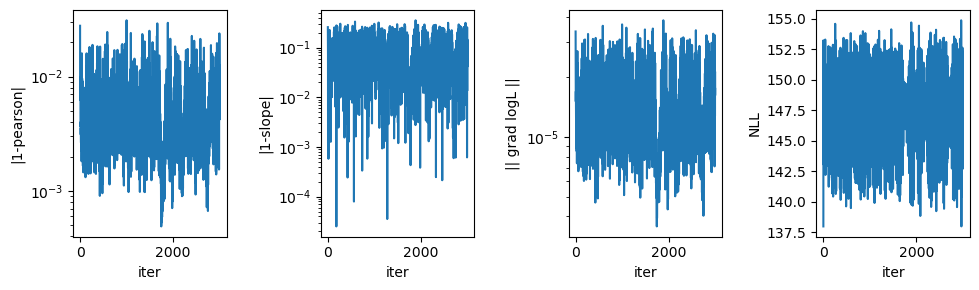

In [220]:
callbacks[0].plot();

<IPython.core.display.Latex object>

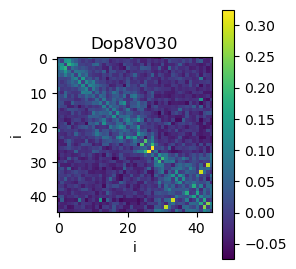

In [227]:
from IPython.display import display, Latex

potts_target = model.selection.modes[0]
potts_target = potts_target.set_zerosum_gauge()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_target.J.detach())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()
# im.set_clim(-0.0015, 0.0030)
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))

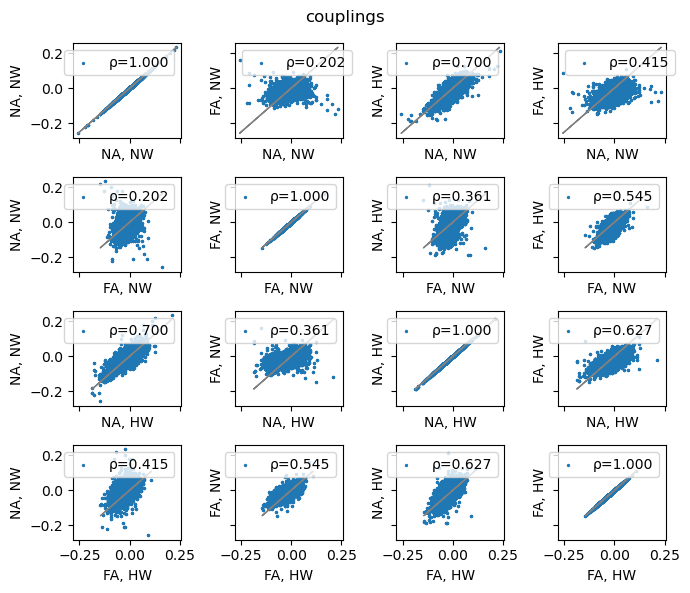

In [234]:
fig, axes = plt.subplots(n_modes, n_modes, sharex=True, sharey=True, figsize=(7,6))

for i in range(n_modes):
    for j in range(n_modes):
        ax = axes[i,j]
        x = model.selection.modes[i].set_zerosum_gauge().J.detach().reshape(-1)
        y = model.selection.modes[j].set_zerosum_gauge().J.detach().reshape(-1)
        rho = torch.corrcoef(torch.stack((x,y)))[0,1].item()
        ax.scatter(x, y, s=2, label=f'ρ={rho:.3f}')
        ax.legend()
        ax.plot(x, x, color='gray', lw=1)
        ax.set_xlabel(mode_names[i])
        ax.set_ylabel(mode_names[j])
fig.suptitle('couplings')
fig.tight_layout()

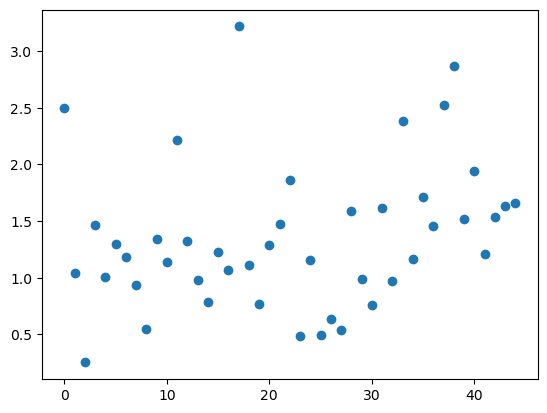

In [222]:
h_norm_target = torch.sqrt(torch.square(potts_zerosum.h.cpu().detach().clone()).sum(1))
plt.scatter(range(L), h_norm_target)

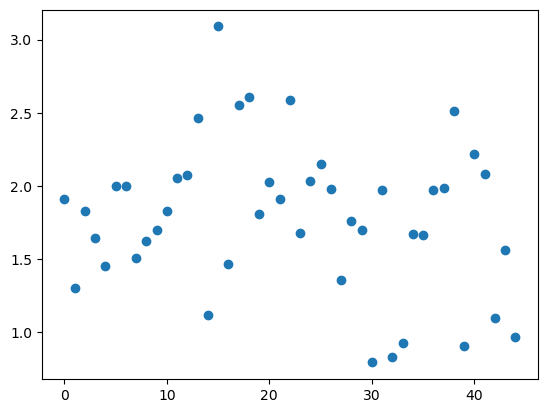

In [109]:
h_norm_bead = torch.sqrt(torch.square(model.selection.modes[1].h.cpu().detach().clone()).sum(1))
plt.scatter(range(L), h_norm_bead)

In [79]:
from IPython.display import display, Latex

potts_zerosum = potts_bead.set_zerosum_gauge()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_zerosum.J.detach())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()
# im.set_clim(-0.0015, 0.0030)
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))

NameError: name 'potts_bead' is not defined

In [80]:
plt.scatter(potts_bead.J.cpu().detach(), potts_target.J.cpu().detach())

NameError: name 'potts_bead' is not defined